<a href="https://colab.research.google.com/github/Halashahin1/Prediction_of_Product_Sales/blob/main/project_four_part_3_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
import tensorflow as tf

#Keras
from tensorflow.keras import Sequential
from tensorflow.keras import metrics
from tensorflow.keras.layers import Dense, Dropout

#Sci-kit Learn
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler,OrdinalEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer

from sklearn import set_config
set_config(transform_output='pandas')
pd.set_option('display.max_columns',100)

In [46]:
# Custom function for plotting each metric
def plot_history(history, figsize=(6,12), marker='o'):

    # Get list of metrics from history
    metrics = [c for c in history.history if not c.startswith('val_')]

    ## Separate row for each metric
    fig, axes = plt.subplots(nrows=len(metrics),figsize=figsize)

    # For each metric
    for i, metric_name in enumerate(metrics):

        # Get the axis for the current metric
        ax = axes[i]

        # Get metric from history.history
        metric_values = history.history[metric_name]
        # Get epochs from history
        epochs = history.epoch

        # Plot the training metric
        ax.plot(epochs, metric_values, label=metric_name, marker=marker)

        ## Check if val_{metric} exists. if so, plot:
        val_metric_name = f"val_{metric_name}"
        if val_metric_name in history.history:
            # Get validation values and plot
            metric_values = history.history[val_metric_name]
            ax.plot(epochs,metric_values,label=val_metric_name, marker=marker)

        # Final subplot adjustments
        ax.legend()
        ax.set_title(metric_name)
    fig.tight_layout()

    return fig, axes

In [47]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [81]:
fpath = "/content/drive/MyDrive/adult.csv"
df = pd.read_csv(fpath)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        48842 non-null  object
 2   fnlwgt           48842 non-null  int64 
 3   education        48842 non-null  object
 4   educational-num  48842 non-null  int64 
 5   marital-status   48842 non-null  object
 6   occupation       48842 non-null  object
 7   relationship     48842 non-null  object
 8   race             48842 non-null  object
 9   gender           48842 non-null  object
 10  capital-gain     48842 non-null  int64 
 11  capital-loss     48842 non-null  int64 
 12  hours-per-week   48842 non-null  int64 
 13  native-country   48842 non-null  object
 14  income           48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [82]:
df['workclass'] = df['workclass'].replace('?',np.nan)
df['occupation'] = df['occupation'].replace('?',np.nan)
df['native-country'] = df['native-country'].replace('?',np.nan)
df.dropna(how='any',inplace=True)

In [83]:
df.isnull().sum()

age                0
workclass          0
fnlwgt             0
education          0
educational-num    0
marital-status     0
occupation         0
relationship       0
race               0
gender             0
capital-gain       0
capital-loss       0
hours-per-week     0
native-country     0
income             0
dtype: int64

In [84]:
df.duplicated().sum()

47

In [85]:
df.drop_duplicates(inplace=True)

In [86]:
df.duplicated().sum()

0

In [87]:
df['income'].value_counts()

<=50K    33973
>50K     11202
Name: income, dtype: int64

In [88]:
df['income'].replace(['>50K','<=50K'],[1,0], inplace=True)

In [89]:
X = df.drop(columns='income')
y = df['income']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [90]:
num_cols = X_train.select_dtypes("number").columns
print("Numeric Columns:", num_cols)
impute_median = SimpleImputer(strategy='mean')
scaler = StandardScaler()
num_pipe = make_pipeline(impute_median, scaler)
num_pipe
num_tuple = ('numeric', num_pipe, num_cols)
num_tuple

Numeric Columns: Index(['age', 'fnlwgt', 'educational-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object')


('numeric',
 Pipeline(steps=[('simpleimputer', SimpleImputer()),
                 ('standardscaler', StandardScaler())]),
 Index(['age', 'fnlwgt', 'educational-num', 'capital-gain', 'capital-loss',
        'hours-per-week'],
       dtype='object'))

In [91]:
ohe_cols = X_train.select_dtypes('object').columns
print("OneHotEncoder Columns:", ohe_cols)
impute_na = SimpleImputer(strategy='constant', fill_value = "NA")
ohe_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
ohe_pipe = make_pipeline(impute_na, ohe_encoder)
ohe_tuple = ('categorical', ohe_pipe, ohe_cols)

OneHotEncoder Columns: Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'gender', 'native-country'],
      dtype='object')


In [92]:
col_transformer = ColumnTransformer([num_tuple,ohe_tuple],
                                    verbose_feature_names_out=False)
col_transformer

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['age', 'fnlwgt', 'educational-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object')),
                                ('categorical',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='NA',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'gender', 'native-country'],
      dtype='object'))],
                  verbose_feature_names_out=False)

In [93]:
col_transformer.fit(X_train)

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['age', 'fnlwgt', 'educational-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object')),
                                ('categorical',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='NA',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'gender', 'native-country'],
      dtype='object'))],
                  verbose_feature_names_out=False)

In [94]:
X_train_tf = col_transformer.fit_transform(X_train)
X_test_tf = col_transformer.transform(X_test)

In [95]:
input_shape = X_train_tf.shape[1]
input_shape

104

In [112]:
def build_model():
    model = Sequential()

    model.add(Dense(104,
                input_dim =input_shape,
                activation = 'relu'))
    model.add(Dense(50,
                activation = 'relu'))
    model.add(Dropout(.2))
    model.add(Dense(1, activation = 'sigmoid'))

    # Compile Model
    model.compile(loss = 'bce', optimizer = 'adam',
             metrics=['accuracy', metrics.Precision(), metrics.Recall()])
    return model

In [113]:
clf_model = build_model()
clf_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 104)               10920     
                                                                 
 dense_10 (Dense)            (None, 50)                5250      
                                                                 
 dropout_3 (Dropout)         (None, 50)                0         
                                                                 
 dense_11 (Dense)            (None, 1)                 51        
                                                                 
Total params: 16221 (63.36 KB)
Trainable params: 16221 (63.36 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [114]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_accuracy', patience=5)

In [115]:
history = clf_model.fit(X_train_tf, y_train,
                        validation_split=.2,
                        epochs=50,
                        verbose=0, callbacks = [early_stop])

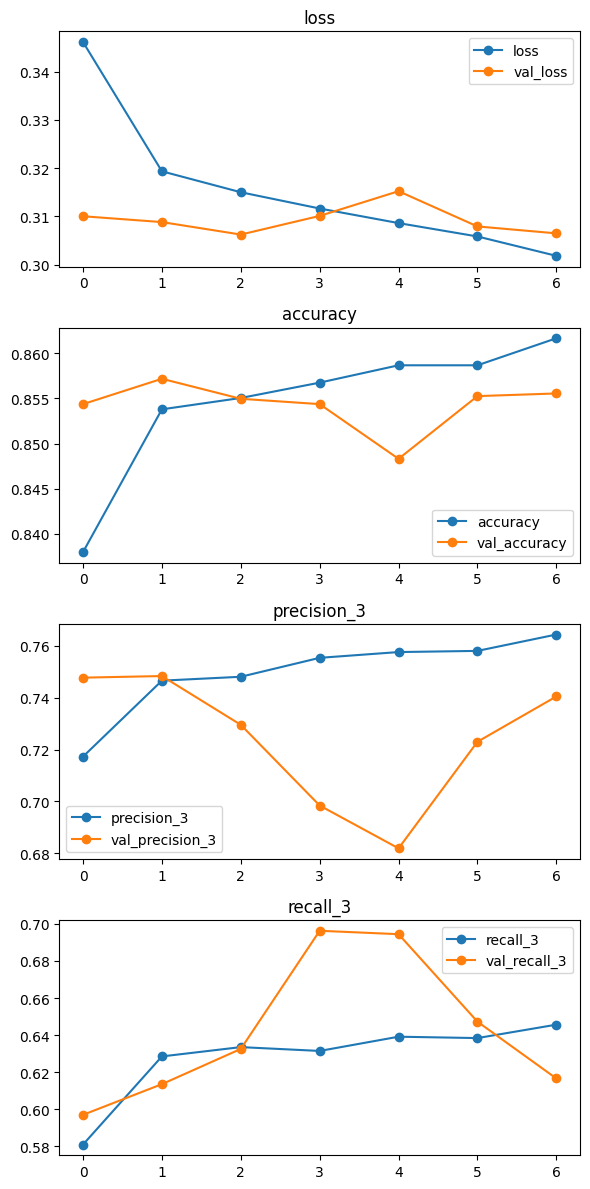

In [116]:
plot_history(history);

In [117]:
y_pred_test = clf_model.predict(X_test_tf)
y_pred_test[:5]

353/353 [==============================] - 1s 2ms/step


array([[9.7145516e-05],
       [1.7472467e-01],
       [1.2364327e-02],
       [6.6519780e-05],
       [9.8528331e-03]], dtype=float32)

In [118]:
y_pred_test = np.round(y_pred_test)
y_pred_test[:5]

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)

              precision    recall  f1-score   support

           0       0.88      0.93      0.90      8501
           1       0.75      0.59      0.66      2793

    accuracy                           0.85     11294
   macro avg       0.81      0.76      0.78     11294
weighted avg       0.84      0.85      0.84     11294



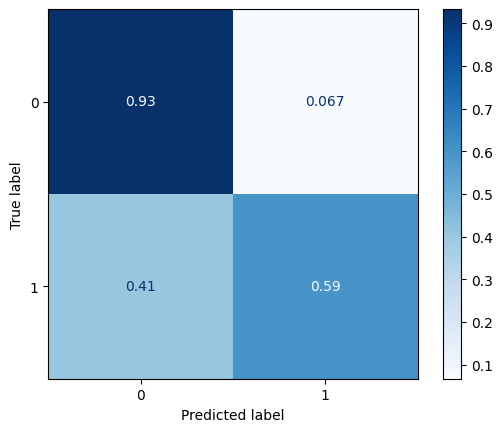

In [119]:
from sklearn.metrics import classification_report,ConfusionMatrixDisplay
print(classification_report(y_test, y_pred_test))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test, cmap='Blues',
                                       normalize='true');

In [129]:
def build_model():
    model = Sequential()

    model.add(Dense(100,
                input_dim =input_shape,
                activation = 'relu'))
    model.add(Dense(60,
                activation = 'relu'))
    model.add(Dense(50,
                activation = 'relu'))
    model.add(Dense(40,
                activation = 'relu'))
    model.add(Dropout(.2))
    model.add(Dense(1, activation = 'sigmoid'))

    # Compile Model
    model.compile(loss = 'bce', optimizer = 'adam',
             metrics=['accuracy', metrics.Precision(), metrics.Recall()])
    return model

In [130]:
clf_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 104)               10920     
                                                                 
 dense_10 (Dense)            (None, 50)                5250      
                                                                 
 dropout_3 (Dropout)         (None, 50)                0         
                                                                 
 dense_11 (Dense)            (None, 1)                 51        
                                                                 
Total params: 16221 (63.36 KB)
Trainable params: 16221 (63.36 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [131]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_accuracy', patience=7)

In [132]:
history = clf_model.fit(X_train_tf, y_train,
                        validation_split=.2,
                        epochs=100,
                        verbose=0, callbacks = [early_stop])

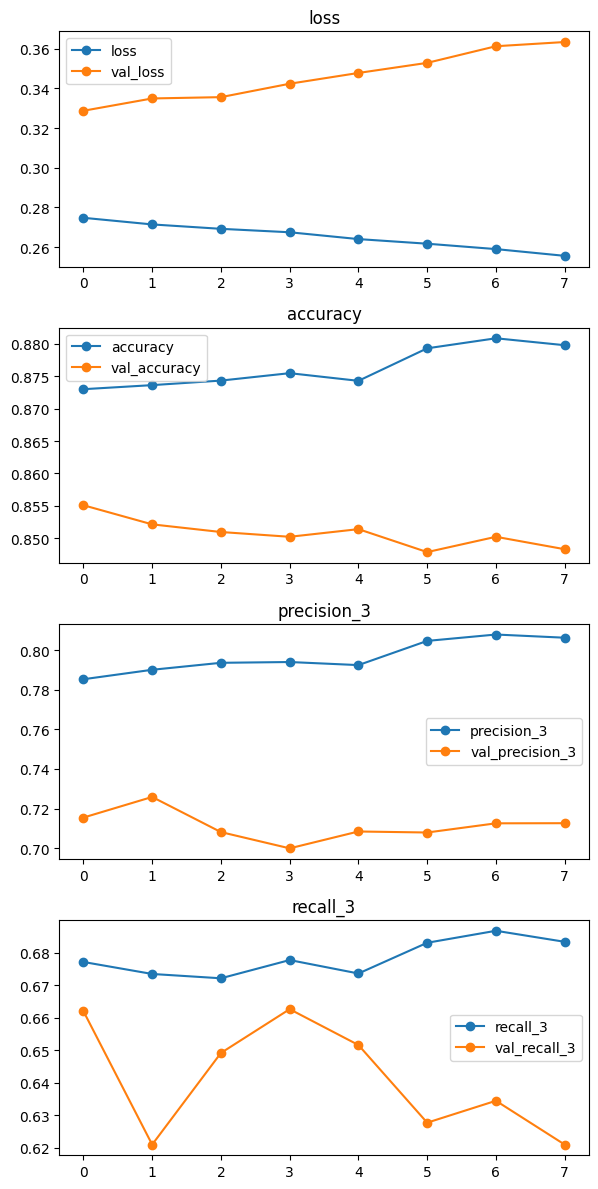

In [133]:
plot_history(history);

In [134]:
y_pred_test = clf_model.predict(X_test_tf)
y_pred_test[:5]

353/353 [==============================] - 1s 2ms/step


array([[9.9478939e-06],
       [1.2653688e-01],
       [1.1121288e-01],
       [4.8412912e-05],
       [1.6303785e-02]], dtype=float32)

In [135]:
y_pred_test = np.round(y_pred_test)
y_pred_test[:5]

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)

              precision    recall  f1-score   support

           0       0.88      0.92      0.90      8501
           1       0.72      0.61      0.66      2793

    accuracy                           0.85     11294
   macro avg       0.80      0.77      0.78     11294
weighted avg       0.84      0.85      0.84     11294



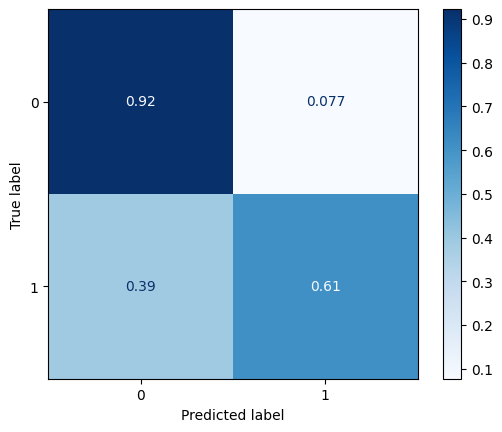

In [136]:
from sklearn.metrics import classification_report,ConfusionMatrixDisplay
print(classification_report(y_test, y_pred_test))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test, cmap='Blues',
                                       normalize='true');